In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
import mapclassify
import folium
from shapely.geometry import point
from util import transpose_create_geoid, plotting, food_desert_map
import sys
sys.argv.append(["--max-memory", "6G"])
import datetime
from r5py import TransportNetwork, TravelTimeMatrixComputer, TransitMode, LegMode

Text(0.5, 1.0, 'Transit Deserts & Proposed Red Line')

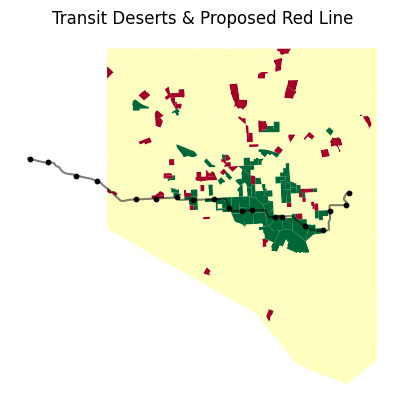

In [2]:
##Transit Desert Index

#2018 Maryland block group shapefile downloaded from: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2018.html#list-tab-790442341
#original Transit Desert Index map: http://www.transitdeserts.info/
#data obtained by contacting research team, uploaded as TD_V1_BAL_cbg.xlsx
#red line KML map downloaded from https://www.google.com/maps/d/u/0/viewer?mid=1-nQTrR-62ggDsL5BaeBK20_X8wA&hl=en_US&ll=0%2C0&z=12
#red line KML map converted to shapfile using https://mygeodata.cloud/converter/kml-to-shp

#create data frame with transit desert index data, add missing data, prepare dataframe for merge
transit_desert = pd.read_excel('TD_V1_BAL_cbg.xlsx')
transit_desert['GEOID'] = transit_desert['GEOID10'].apply(np.int64)
transit_desert.loc[transit_desert['GEOID'] == 245101307003, 'Gap_Zscore TD'] = -0.002674515
transit_desert.loc[transit_desert['GEOID'] == 245101304001, 'Gap_Zscore TD'] = 0.038632496
transit_desert.loc[transit_desert['GEOID'] == 245100401001, 'Gap_Zscore TD'] = 3.7691295

#create geodataframe from 2018 block group shapefile, narrow down to Baltimore City, merge
blocks_map2018 = gp.read_file('tl_2018_24_bg.shp')
blocks_map2018 = blocks_map2018.loc[blocks_map2018['COUNTYFP'] == '510']
blocks_map2018['GEOID'] = blocks_map2018['GEOID'].apply(np.int64)
TDI_map = blocks_map2018.merge(transit_desert, on = 'GEOID')

#create geodataframes of stations and alignment of proposed red line
stations = gp.read_file('Stations-point.shp')
alignment = gp.read_file('Alignment-line.shp')

#plot map of transit desert index and proposed red line
base = TDI_map.plot(column='Gap_Zscore TD', cmap= 'RdYlGn', scheme='user_defined', classification_kwds={'bins':[-1, 1]})
ax = alignment.plot(ax=base, marker='o', color='black', markersize=10, alpha= 0.5)
ax = stations.plot(ax=base, marker='o', color='black', markersize=10)
ax.set_axis_off()
plt.title('Transit Deserts & Proposed Red Line')

In [3]:
##Tract geodataframe

#2021 Maryland census tract shapefile downloaded from: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2021&layergroup=Census+Tracts

#create geodataframe from 2021 census tract shapefile, narrow down to Baltimore City
tract21 = gp.read_file('tl_2021_24_tract.shp')
tract21 = tract21.loc[tract21["COUNTYFP"] == "510"]
tract21['GEOID'] = tract21['GEOID'].astype('Int64')

Text(0.5, 1.0, 'Baltimore Grocery Stores')

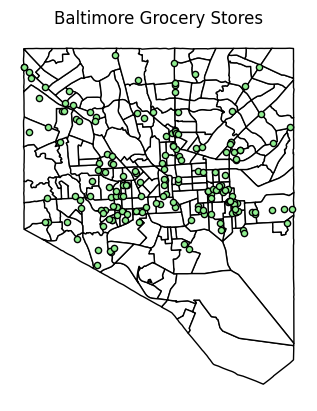

In [4]:
##Baltimore grocery store data

#download data from: https://auth.data-axle.com/signups/new?client_id=aa896f8ee71ef28c99a9b997&information_uri=https%3A%2F%2Fplatform.data-axle.com%2Fsignup_information
#Primary NAICS code for grocery stores (excluding convenience) is 445110

#create dataframe using DataAxle data for Baltimore, narrow down to Baltimore's City's county id code
food_retailers = pd.read_csv("BaltimoreFoodRetailers-00000_places.csv.gz")
food_retailers = food_retailers[food_retailers["fips_code"] == 24510]
food_map = gp.GeoDataFrame(
    food_retailers, geometry=gp.points_from_xy(food_retailers.longitude, food_retailers.latitude), crs="EPSG:4326"
)
food_map['id'] = food_map.index

#plot grocery store location on Baltimore City block group map
base = tract21.plot(color='white', edgecolor='black')
food_map.plot(ax=base, marker='o', facecolor='lightgreen', markersize=20, edgecolor = 'black')
base.set_axis_off()
plt.title('Baltimore Grocery Stores')

<Axes: title={'center': 'Percentage of Households without Vehicles'}>

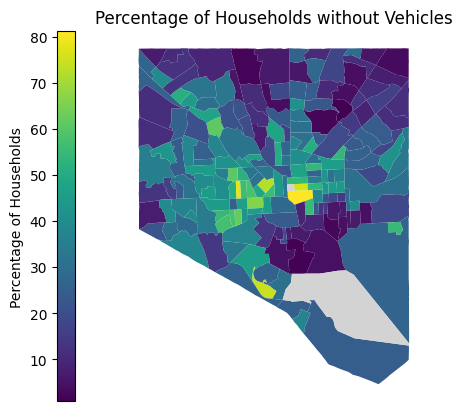

In [5]:
##Vehicles available by household

#data downloaded from: https://data.census.gov/table?q=Transportation&g=050XX00US24510$1400000&tid=ACSDT5Y2021.B08141&moe=false
#"B08203", 2021: ACS 5-Year Estimates Detailed Tables

#read cvs file, transpose, and format
vehicle_household = pd.read_csv('ACSDT5Y2021.B08203-2023-08-07T214015.csv', thousands = ',')
vehicle_household = transpose_create_geoid(vehicle_household)
vehicle_household['Total Households'] = vehicle_household['Total:'].astype(float)
vehicle_household['No Vehicle'] = vehicle_household['    No vehicle available'].astype(float)

#calculate percentage of households without a vehicle
vehicle_household['Percent No Vehicle'] = vehicle_household['No Vehicle']/vehicle_household['Total Households']*100

#restrict number of columns to avoid repeating column names
vehicle_household = vehicle_household[['Percent No Vehicle','No Vehicle','GEOID']]

#merge with geodataframe
vehicle_household_map = tract21.merge(vehicle_household, on='GEOID')

#plot map of percentage of households without a vehicle by tract
plotting(vehicle_household_map, 'Percent No Vehicle', 'Percentage of Households', 'Percentage of Households without Vehicles')

<Axes: title={'center': 'Median Household Income'}>

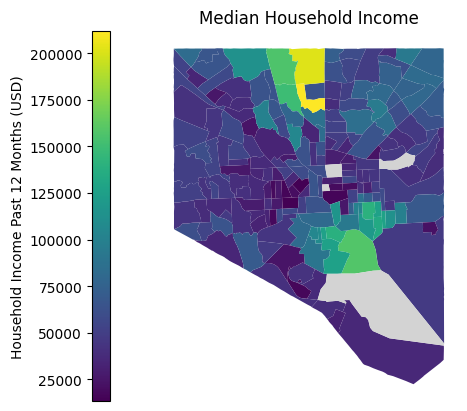

In [6]:
##Median household income

#data downloaded from: https://data.census.gov/table?q=B19013&g=050XX00US24510$1400000&tid=ACSDT5Y2021.B19013&moe=false
#"B19013", 2021: ACS 5-Year Estimates Detailed Tables

#read cvs file, transpose, format, and merge with geodataframe
median_house_income = pd.read_csv('ACSDT5Y2021.B19013-2023-08-12T151751.csv', thousands = ',')
median_house_income = transpose_create_geoid(median_house_income)
median_house_income['Median Household Income'] = median_house_income['Median household income in the past 12 months (in 2021 inflation-adjusted dollars)'].astype(float)
median_house_income_map = tract21.merge(median_house_income, on='GEOID')

#calculate 80% of Baltimore's median household income
baltimore_median80 = 54652*.8

#plot median household income by tract
plotting(median_house_income_map, 'Median Household Income', 'Household Income Past 12 Months (USD)', 'Median Household Income')

<Axes: title={'center': 'Population Living Below Poverty (Percent)'}>

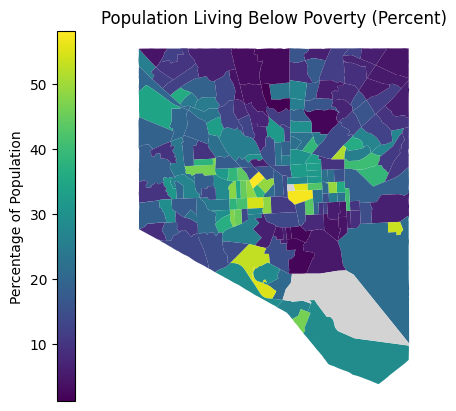

In [7]:
##Income below poverty

#data downloaded from: https://data.census.gov/table?t=Income+and+Poverty&g=050XX00US24510$1400000&tid=ACSDT5Y2021.B17101&moe=false
#"B17101", 2021: ACS 5-Year Estimates Detailed Tables

#create data frame with 2021 ACS poverty data and transpose
poverty_level = pd.read_csv('ACSDT5Y2021.B17101-2023-08-09T202711.csv', thousands = ',')
poverty_level = transpose_create_geoid(poverty_level)
poverty_level['Total Population'] = poverty_level['Total:'].astype(float)
poverty_level['Income Below Poverty'] = poverty_level['    Income in the past 12 months below poverty level'].astype(float)

#calculate the percentage of the total population with income below poverty
poverty_level['Percent Poverty'] = poverty_level['Income Below Poverty']/poverty_level['Total Population']*100

#merge with census tract geodataframe
poverty_level_map = tract21.merge(poverty_level, on='GEOID')

#plot percentage of population with income below poverty level in past 12 months by tract
plotting(poverty_level_map, 'Percent Poverty', 'Percentage of Population', 'Population Living Below Poverty (Percent)')

<Axes: title={'center': 'Population Living Below Double Poverty (Percent)'}>

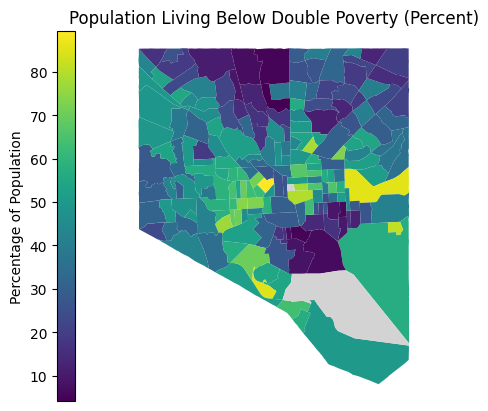

In [8]:
##Income below double/200% of the poverty level

#data downloaded from: https://data.census.gov/table?t=Income+and+Poverty&g=050XX00US24510$1400000&tid=ACSST5Y2021.S1701&moe=false
#"S1701", 2021: ACS 5-Year Estimates Detailed Tables

#create data frame with 2021 ACS double poverty data and transpose
double_poverty = pd.read_csv('ACSST5Y2021.S1701-2023-08-14T134107.csv')
double_poverty = transpose_create_geoid(double_poverty)

double_poverty = double_poverty.loc[double_poverty['        200 percent of poverty level'] != '(X)']
double_poverty['Population'] = double_poverty['Population for whom poverty status is determined'].str.replace(',','').astype(float)
double_poverty['Double Poverty'] = double_poverty['        200 percent of poverty level'].str.replace(',','').astype(float)

#calculate the percentage of the population with income below double the poverty level
double_poverty['Percent Double Poverty'] = double_poverty['Double Poverty']/double_poverty['Population']*100

#restrict number of columns to avoid repeating column names
double_poverty = double_poverty[['Double Poverty','Percent Double Poverty','GEOID']]

#merge with census tract geodataframe
double_poverty_map = tract21.merge(double_poverty, on='GEOID')

#plot percentage of population with income below double the poverty level by tract
plotting(double_poverty_map, 'Percent Double Poverty', 'Percentage of Population', 'Population Living Below Double Poverty (Percent)')


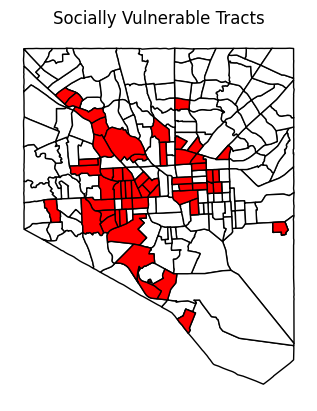

In [9]:
#merge dataframes and identify socially vulnerable tracts
social_vulnerability = vehicle_household_map.merge(median_house_income, on = 'GEOID').merge(poverty_level, on = 'GEOID').merge(double_poverty, on = 'GEOID')
social_vulnerability = social_vulnerability.loc[(social_vulnerability['Percent Poverty'] > 20) & (social_vulnerability['Median Household Income'] < baltimore_median80) & (social_vulnerability['Percent No Vehicle'] > 30) & (social_vulnerability['Percent Double Poverty'] >40)]

#plot socially vulnerable tracts
base = tract21.plot(color = 'white', edgecolor = 'black')
social_vulnerability.plot(ax=base, color = 'red', edgecolor = 'black')
plt.title('Socially Vulnerable Tracts')
base.set_axis_off()

In [10]:
#shapefile downloaded from: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2021&layergroup=Block+Groups

#create block group geodataframe from 2021 Maryland block group shapefile, narrow down to Baltimore City
blockgroup21 = gp.read_file('cb_2021_24_bg_500k.shp')
blockgroup21 = blockgroup21.loc[blockgroup21["COUNTYFP"] == "510"]
blockgroup21['GEOID'] = blockgroup21['GEOID'].astype('Int64')
#find centroids of block groups
blockgroup_centroids = blockgroup21.to_crs(6487) 
blockgroup_centroids['geometry'] = blockgroup_centroids['geometry'].centroid
blockgroup_centroids = blockgroup_centroids.to_crs(4326) 
blockgroup_centroids = blockgroup_centroids.reset_index()
blockgroup_centroids['id'] = blockgroup_centroids.index

In [11]:
#create transport network using GTFS data (check util.py for download)
osm_fp = "maryland-latest.osm.pbf"
transport_network = TransportNetwork(
    osm_fp,
    [
        "GTFS\mdotmta_gtfs_commuter-bus.zip", 
        "GTFS\mdotmta_gtfs_light-rail.zip",
        "GTFS\mdotmta_gtfs_local-bus.zip",
        "GTFS\mdotmta_gtfs_marc.zip",
        "GTFS\mdotmta_gtfs_metro.zip"
    ]
)

In [12]:
#create travel time matrix for public transport (from each block group centroid to each grocery store)
travel_time_matrix_computer = TravelTimeMatrixComputer(
    transport_network,
    origins= blockgroup_centroids,
    destinations= food_map,
    departure=datetime.datetime(2023,7,30,17,30),
    transport_modes=[TransitMode.TRANSIT, LegMode.WALK],
)
ttm_public_transport = travel_time_matrix_computer.compute_travel_times()

c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:395: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLon = origin.x
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

<Axes: title={'center': 'PUBLIC TRANSPORT'}>

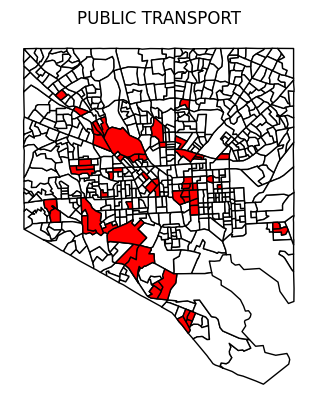

In [13]:
#plot socially vulnerable tracts where the closest grocery store is farther than 10 minutes away by public transport
food_desert_map(ttm_public_transport, 'PUBLIC TRANSPORT', blockgroup_centroids, blockgroup21, social_vulnerability)

In [14]:
#create travel time matrix for walking (from each block group centroid to each grocery store)
tc_walk = TravelTimeMatrixComputer(
    transport_network,
    origins = blockgroup_centroids,
    destinations = food_map,
    transport_modes=[LegMode.WALK],
)
ttm_walk = tc_walk.compute_travel_times()

c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:395: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLon = origin.x
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

<Axes: title={'center': 'WALKING'}>

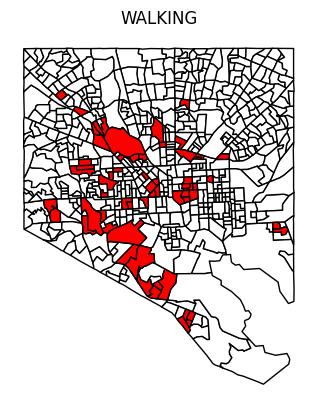

In [15]:
#plot socially vulnerable tracts where the closest grocery store is farther than 10 minutes away by foot
food_desert_map(ttm_walk, 'WALKING', blockgroup_centroids, blockgroup21, social_vulnerability)

In [16]:
#create travel time matrix for biking (from each block group centroid to each grocery store)
tc_bike = TravelTimeMatrixComputer(
    transport_network,
    origins = blockgroup_centroids,
    destinations = food_map,
    speed_cycling=16,
    transport_modes=[LegMode.BICYCLE],
)
ttm_bike = tc_bike.compute_travel_times()

c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:395: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLon = origin.x
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:394: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._regional_task.fromLat = origin.y
c:\Users\user\Desktop\Python\venv\Lib\site-packages\r5py\r5\regional_task.py:395: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

<Axes: title={'center': 'BIKING'}>

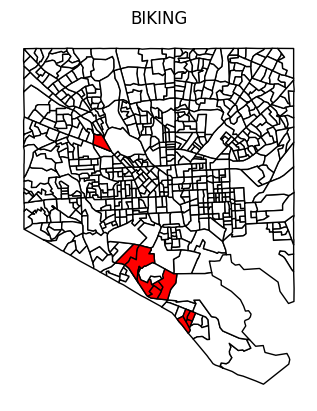

In [17]:
#plot socially vulnerable tracts where the closest grocery store is farther than 10 minutes away by bike
food_desert_map(ttm_bike, 'BIKING', blockgroup_centroids, blockgroup21, social_vulnerability)

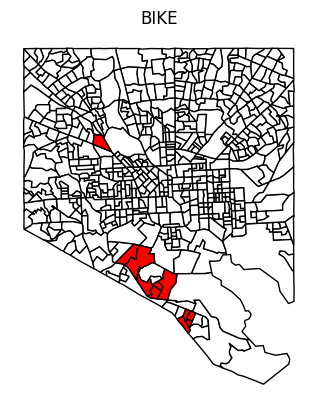

In [18]:
#make new dataframe with shortest travel time
bike_short = ttm_bike.groupby('from_id')['travel_time'].min().reset_index()
bike_short = blockgroup_centroids.merge(bike_short, left_on = 'id', right_on = 'from_id')
bike_short = bike_short.to_crs(4269)
#join with block group map and identify the block groups in which the shortest travel time exceeds 10 minutes
bike_short = blockgroup21.sjoin(bike_short)
bike_short['GEOID'] = bike_short['GEOID_left'].astype(str).str.slice(stop=11).astype('int64')
bike_short = bike_short.loc[bike_short['travel_time'] >= 10]
#identifyblock groups which are located in socially vulnerable tracts and have low access to grocery stores
bike_short = bike_short[['GEOID', 'geometry']]
bike_short = bike_short.merge(social_vulnerability, on = 'GEOID')
bike_short = bike_short.set_geometry('geometry_x')
base = blockgroup21.plot(color = 'white', edgecolor = 'black')
bike_short.plot(color = 'red', ax = base, edgecolor = 'black')
plt.title('BIKE')
base.set_axis_off()